# Library import

In [302]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

import scipy
from scipy import signal
from scipy import stats
from scipy import ndimage

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage.measure import regionprops, label
from skimage import morphology
from skimage import segmentation
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.feature import peak_local_max

import sympy as sp

import oiffile as oi

# Image

In [ ]:
# Import image file (if you have .tiff):
#img_raw = io.imread(r"C:\Users\valusty\sync\Implants\Histochemical results\Valeriia Ustymenko\0524\060524\280923_1l1r_silicont\10_mbp_nfh_40x\10_mbp_nfh_40x.tif")

# Import image file (if you have .tiff):
#img_raw = oi.imread(r"C:\Users\valusty\sync\Ustymenko\Image\1024\241024\02_co_ps_221024\01_03_co_ps_40x.oib")

#Check shape of data
print(img_raw.shape)

(2, 31, 1024, 1024)


In [ ]:


name = "01_03_co_ps_40x.oib"

date = "241024"

op_date = "co"

group = "co"
#group = "s_tube"
#group = "eptfe"
#group = "autoneuropl"

#paw = "xl1r"
paw = "co"

spot = "ps"
#spot = "ds"
#spot = "tube"

## For multichannel

In [305]:
ch0_img_raw = img_raw[0]
ch1_img_raw = img_raw[1]

print(ch0_img_raw.shape) 
print(ch1_img_raw.shape) 

(31, 1024, 1024)
(31, 1024, 1024)


### Max image projection

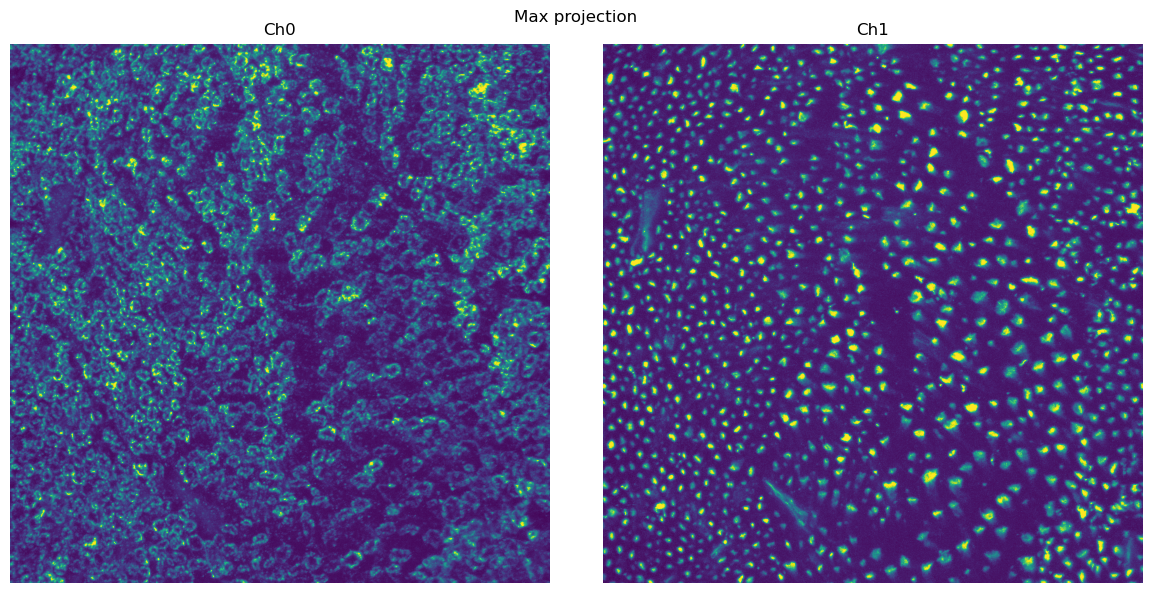

In [306]:
# проекції максимума для окремих каналів
ch0_img_raw_max = np.max(ch0_img_raw, axis=0)
ch1_img_raw_max = np.max(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_max)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_max)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Max projection')

plt.tight_layout()
plt.show()

## Blep blop blap

### Preview

In [307]:
# приклад функції
def img_metrics(img):
    print(f'Minimal intensity ={np.min(img)}')
    print(f'Maximal intensity ={np.max(img)}')
    print(f'Average intensity ={np.mean(img)}')
    print(f'Median intensity ={np.median(img)}')

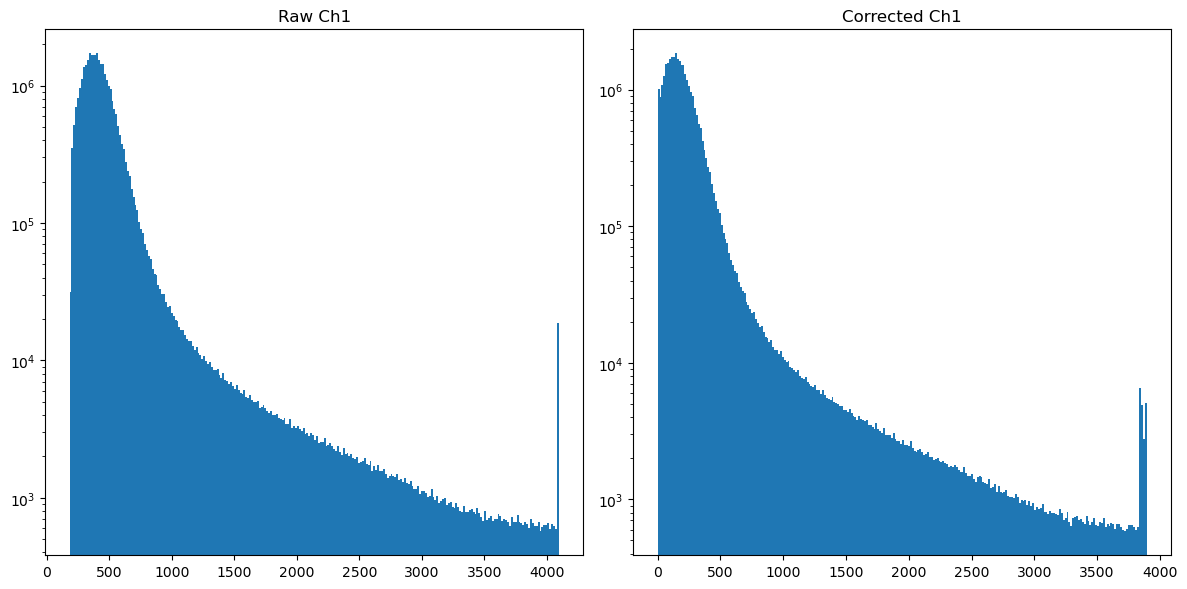

In [308]:
bc_p = lambda x:np.array([f - np.percentile(f, 1) for f in x]).clip(min=0).astype(dtype=x.dtype)

ch0_img_corr = bc_p(ch0_img_raw)
ch1_img_corr = bc_p(ch1_img_raw)

#plot
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6))

ax0.hist(ch1_img_raw.ravel(), bins=256)
ax0.set_yscale('log')
ax0.set_title('Raw Ch1')

ax1.hist(ch1_img_corr.ravel(), bins=256)
ax1.set_yscale('log')
ax1.set_title('Corrected Ch1')

plt.tight_layout()
plt.show()

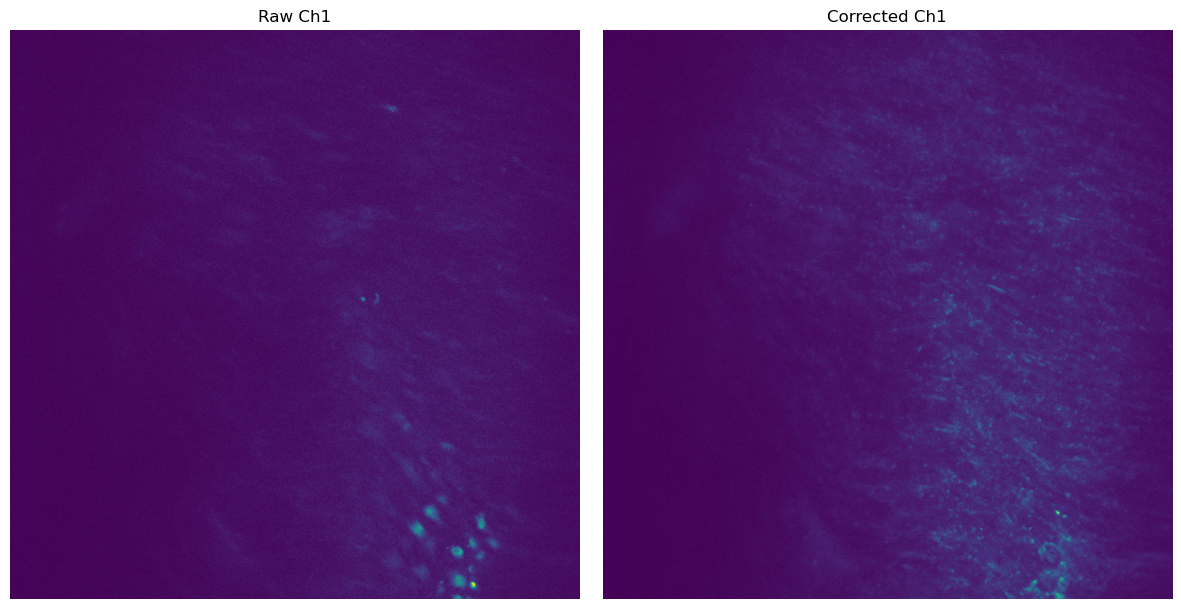

In [309]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6))

ax0.imshow(ch1_img_raw[0])
ax0.set_title('Raw Ch1')
ax0.axis('off')

ax1.imshow(ch0_img_corr[0])
ax1.set_title('Corrected Ch1')
ax1.axis('off')

plt.tight_layout()
plt.show()

### Median Filter

In [310]:
#channel_corr = img_raw
#channel_corr = ch0_img_corr
channel_corr = ch1_img_corr

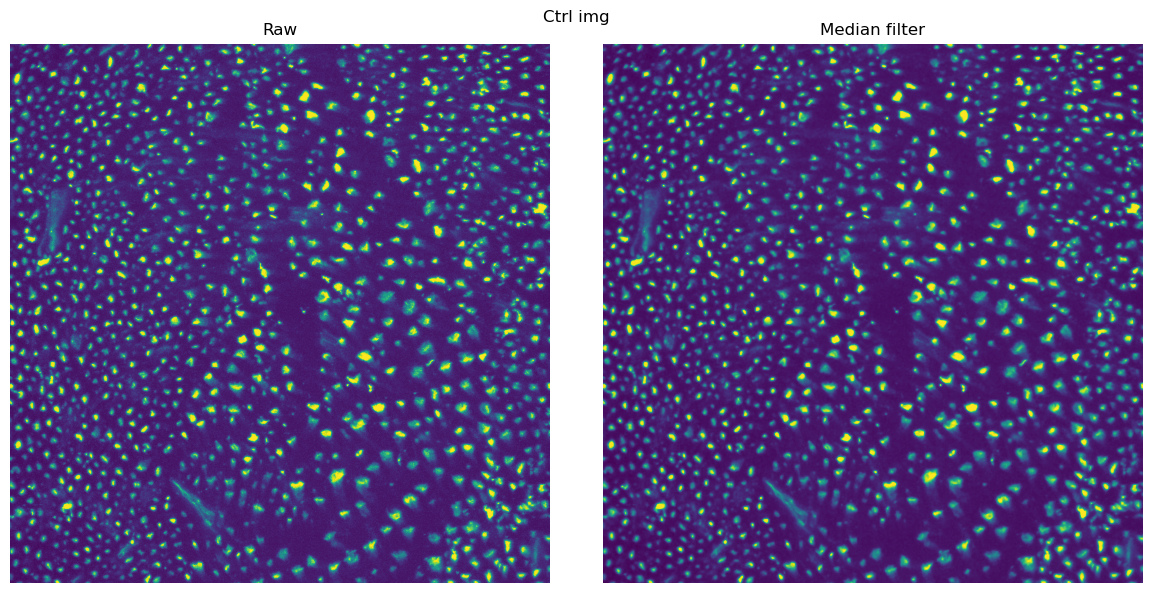

In [311]:
# контрольне зображення для детекції
nfh_det_img_raw = np.max(channel_corr, axis=0)

# фільтрування контрольного зображення
morphology_disk = 2
nfh_det_img = filters.median(nfh_det_img_raw,
                              footprint=morphology.disk(morphology_disk))


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # сире контрольне зображення
ax0.imshow(nfh_det_img_raw)
ax0.set_title('Raw')
ax0.axis('off')

ax1 = plt.subplot(122)  # контрольне зображення після застосування фільтра Гауса
ax1.imshow(nfh_det_img)
ax1.set_title('Median filter')
ax1.axis('off')

plt.suptitle('Ctrl img')

plt.tight_layout()
plt.show()

### Threshold Otsu

[1037 2353]


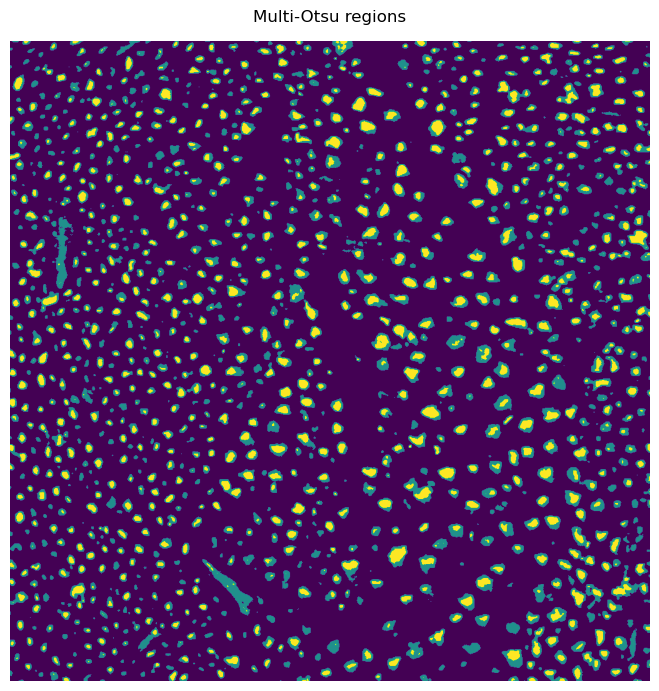

In [312]:
# отримання порогів мульти-Отсу
thresholds = filters.threshold_multiotsu(nfh_det_img)
print(thresholds)

# розмежування регіонів за пороговими значеннями
regions_img = np.digitize(nfh_det_img, bins=thresholds)


# plot
plt.figure(figsize=(10,7))
plt.imshow(regions_img)  # регіони за порогами мульти-Отсу
plt.suptitle('Multi-Otsu regions')
plt.axis('off')

plt.tight_layout()
plt.show()

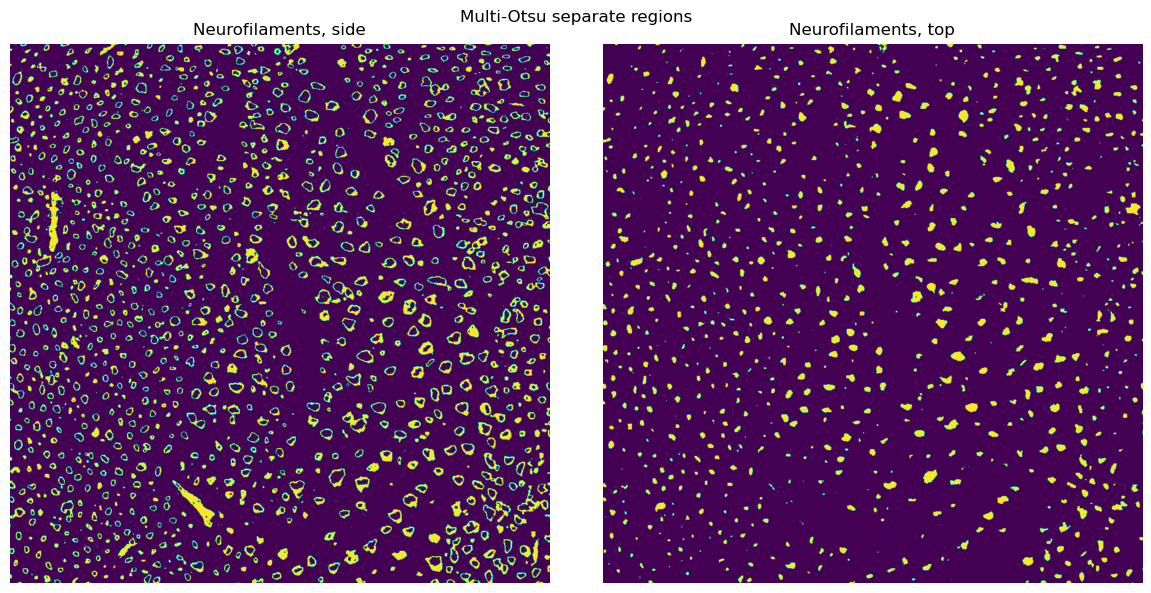

In [313]:
# булеві маски окремих регіонів
length_mask_raw = regions_img == 1
top_mask_raw = regions_img == 2

# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон бічний
ax0.imshow(length_mask_raw)
ax0.set_title('Neurofilaments, side')
ax0.axis('off')

ax1 = plt.subplot(122)  # регіон зрізу
ax1.imshow(top_mask_raw)
ax1.set_title('Neurofilaments, top')
ax1.axis('off')

plt.suptitle('Multi-Otsu separate regions')

plt.tight_layout()
plt.show()

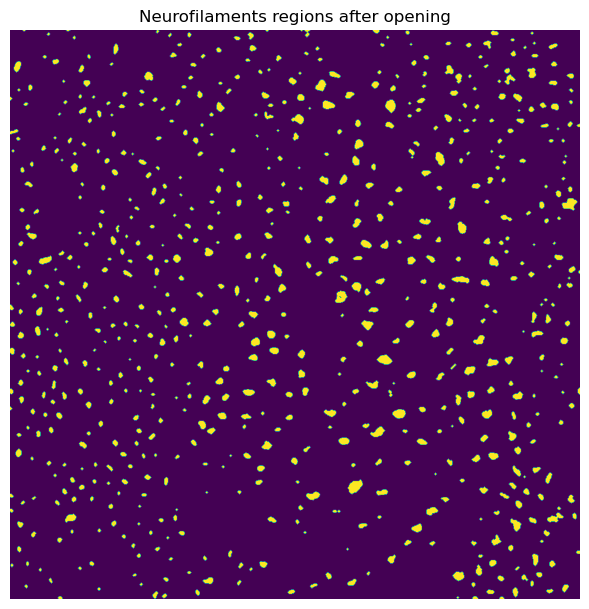

In [314]:
nfh_mask = morphology.opening(top_mask_raw, footprint=morphology.disk(2))

# plot
plt.figure(figsize=(12,6))

ax1 = plt.subplot(122)
ax1.imshow(nfh_mask)
ax1.set_title('Neurofilaments regions after opening')
ax1.axis('off')

plt.tight_layout()
plt.show()

In [315]:
distance = ndimage.distance_transform_edt(nfh_mask.astype(bool))
local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=nfh_mask)
peaks_mask = np.zeros_like(distance, dtype=bool)
peaks_mask[tuple(local_maxi.T)] = True
markers = morphology.label(peaks_mask)
labels_ws = watershed(-distance, markers, mask=nfh_mask)
ans = mark_boundaries(nfh_mask, labels_ws, color=(1, 1, 0), outline_color=(1,0,1), mode='inner', background_label=0)

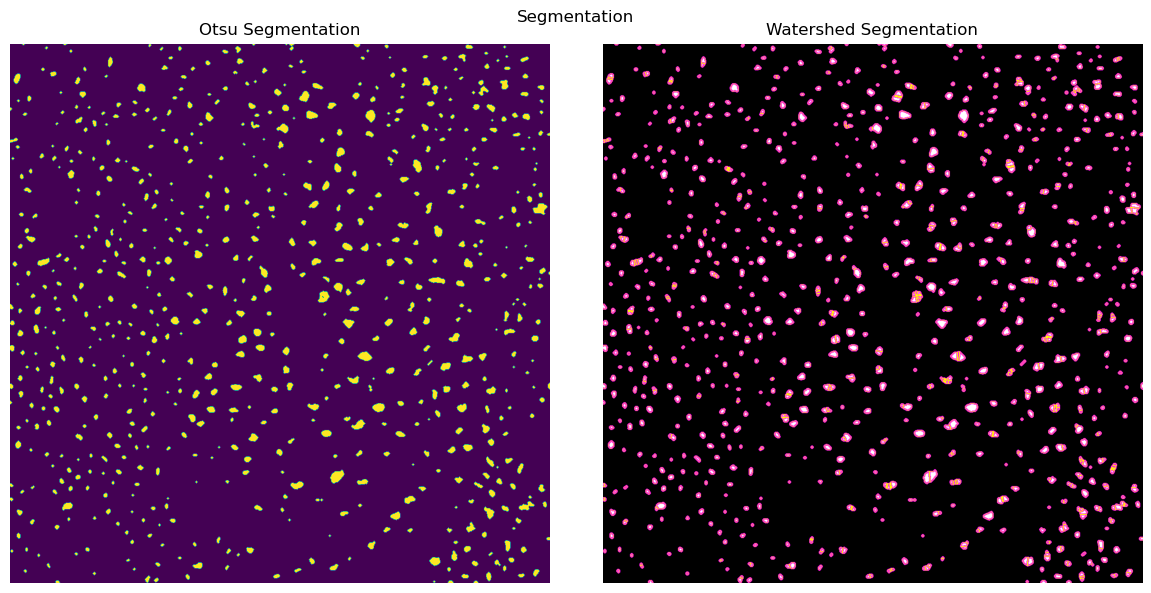

In [316]:
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)
ax0.imshow(nfh_mask )
ax0.set_title('Otsu Segmentation')
ax0.axis('off')

#ax1 = plt.subplot(122)
#ax1.imshow(distance)
#ax1.set_title('Distance Transform')
#ax1.axis('off')

#ax2 = plt.subplot(122)
#ax[2].imshow(peaks_mask)
#ax[2].set_title('Local Maxima')
#ax[2].axis('off')

ax1 = plt.subplot(122)
ax1.imshow(ans)
ax1.set_title('Watershed Segmentation')
ax1.axis('off')

plt.suptitle('Segmentation')

plt.tight_layout()
plt.show()

In [317]:
nfh_quantity = measure.regionprops(labels_ws)
#nfh_quantity = measure.regionprops(markers)

region_data = []


for region in nfh_quantity:
    region_data.append({
        "label": region.label,
        "area": region.area*0.317,
        "minor_length": region.axis_minor_length*0.317,
        "major_length": region.axis_major_length*0.317
    })

df = pd.DataFrame(region_data)
print(df)

      label    area  minor_length  major_length
0         1   7.291      1.302333      2.418188
1         2   9.510      1.300413      3.100023
2         3   7.608      1.592029      1.971186
3         4   5.072      1.227736      1.677406
4         5  15.533      1.838065      3.722127
...     ...     ...           ...           ...
999    1000  15.850      2.166846      2.983162
1000   1001   4.121      1.315866      1.315866
1001   1002  10.778      1.643919      2.720673
1002   1003  13.314      1.671883      3.347509
1003   1004   9.827      1.459964      2.862641

[1004 rows x 4 columns]


In [318]:
# major_length_um = lambda region: float(region.axis_major_length) * 0.317
# minor_length_um = lambda region: float(region.axis_minor_length) * 0.317

# def major_length_um(region):
#     return float(region.axis_major_length) * 0.317
# def minor_length_um(region):
#     return float(region.axis_minor_length) * 0.317

nfh_quantity_df = measure.regionprops_table(labels_ws, intensity_image=nfh_det_img, properties=("label", "intensity_mean", "area", "axis_major_length", "axis_minor_length"))
nfh_quantity_df['major_length_um'] = nfh_quantity_df['axis_major_length'] * 0.317
nfh_quantity_df['minor_length_um'] = nfh_quantity_df['axis_minor_length'] * 0.317
# nfh_quantity_df['axis_ratio'] = np.divide(nfh_quantity_df['axis_major_length'], nfh_quantity_df['axis_minor_length'])
nfh_quantity_df['axis_ratio'] = np.divide(nfh_quantity_df['axis_minor_length'], nfh_quantity_df['axis_major_length'])
#nfh_quantity_df = pd.DataFrame(nfh_quantity_df)
nfh_quantity_df['name'] = name
nfh_quantity_df['date'] = date
nfh_quantity_df['op_date'] = op_date
nfh_quantity_df['group'] = group
nfh_quantity_df['paw'] = paw 
nfh_quantity_df['spot'] = spot
nfh_quantity_df = pd.DataFrame(nfh_quantity_df)

nfh_quantity_df

label  intensity_mean  area  axis_major_length  axis_minor_length  \
0         1     2984.913043  23.0           7.628352           4.108307   
1         2     3107.533333  30.0           9.779252           4.102249   
2         3     3088.500000  24.0           6.218253           5.022173   
3         4     2612.937500  16.0           5.291503           3.872983   
4         5     2541.795918  49.0          11.741726           5.798312   
...     ...             ...   ...                ...                ...   
999    1000     2666.460000  50.0           9.410605           6.835475   
1000   1001     2516.230769  13.0           4.150996           4.150996   
1001   1002     3426.529412  34.0           8.582566           5.185865   
1002   1003     3368.309524  42.0          10.559966           5.274080   
1003   1004     3289.774194  31.0           9.030415           4.605566   

      major_length_um  minor_length_um  axis_ratio                 name  \
0            2.418188         1.302333    0.538558  01_03_co_ps_40x.oib   
1            3.100023         1.300413    0.419485  01_03_co_ps_40x.oib   
2            1.971186         1.592029    0.807650  01_03_co_ps_40x.oib   
3            1.677406         1.227736    0.731925  01_03_co_ps_40x.oib   
4            3.722127         1.838065    0.493821  01_03_co_ps_40x.oib   
...               ...              ...         ...                  ...   
999          2.983162         2.166846    0.726359  01_03_co_ps_40x.oib   
1000         1.315866         1.315866    1.000000  01_03_co_ps_40x.oib   
1001         2.720673         1.643919    0.604233  01_03_co_ps_40x.oib   
1002         3.347509         1.671883    0.499441  01_03_co_ps_40x.oib   
1003         2.862641         1.459964    0.510006  01_03_co_ps_40x.oib   

        date op_date group paw spot  
0     241024      co    co  co   ps  
1     241024      co    co  co   ps  
2     241024      co    co  co   ps  
3     241024      co    co  co   ps  
4     241024      co    co  co   ps  
...      ...     ...   ...  ..  ...  
999   241024      co    co  co   ps  
1000  241024      co    co  co   ps  
1001  241024      co    co  co   ps  
1002  241024      co    co  co   ps  
1003  241024      co    co  co   ps  

[1004 rows x 14 columns]

(0.0, 5.5)

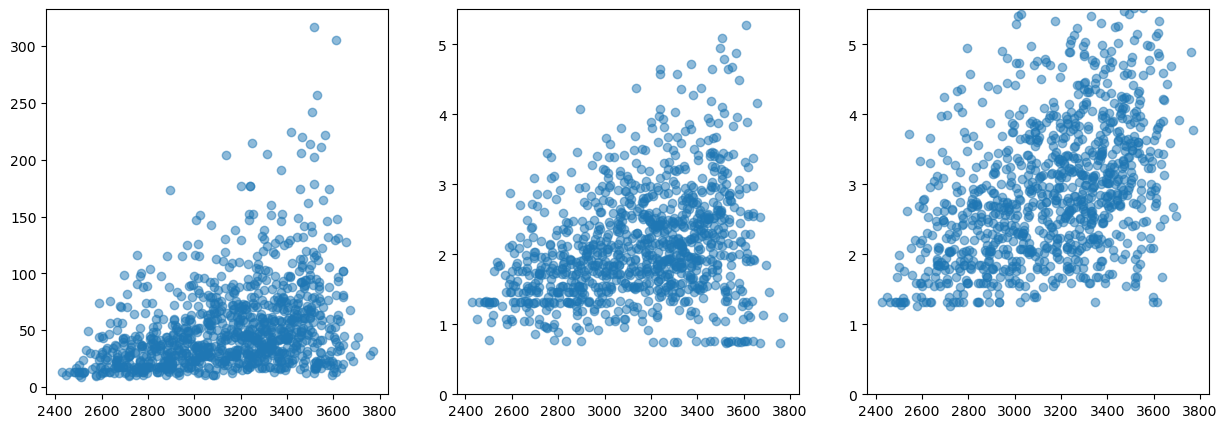

In [319]:

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].scatter(nfh_quantity_df['intensity_mean'], nfh_quantity_df['area'],  alpha=.5)
ax[1].scatter(nfh_quantity_df['intensity_mean'], nfh_quantity_df['minor_length_um'], alpha=.5)
ax[1].set_ylim(0,5.5)
ax[2].scatter(nfh_quantity_df['intensity_mean'], nfh_quantity_df['major_length_um'], alpha=.5)
ax[2].set_ylim(0,5.5)


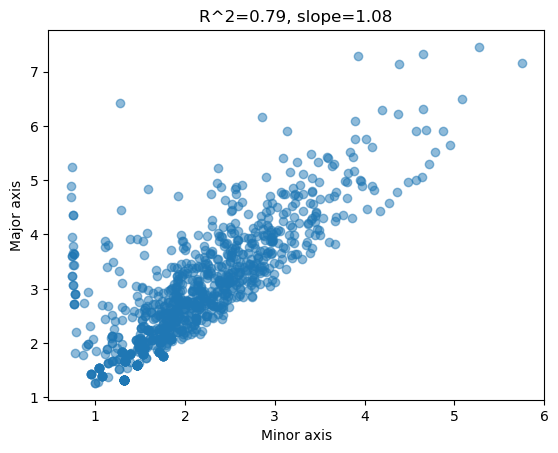

In [320]:
axis_lm = stats.linregress(nfh_quantity_df['minor_length_um'], nfh_quantity_df['major_length_um'])

plt.scatter(nfh_quantity_df['minor_length_um'], nfh_quantity_df['major_length_um'], alpha=.5)
plt.xlabel('Minor axis')
plt.ylabel('Major axis')
plt.title(f'R^2={axis_lm.rvalue :.2f}, slope={axis_lm.slope :.2f}')
plt.show()

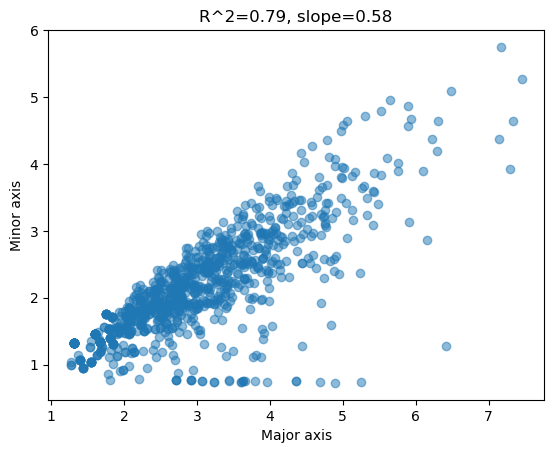

In [321]:
axis_lm = stats.linregress(nfh_quantity_df['major_length_um'], nfh_quantity_df['minor_length_um'])

plt.scatter(nfh_quantity_df['major_length_um'], nfh_quantity_df['minor_length_um'], alpha=.5)
plt.xlabel('Major axis')
plt.ylabel('Minor axis')
plt.title(f'R^2={axis_lm.rvalue :.2f}, slope={axis_lm.slope :.2f}')
plt.show()

In [322]:
def slice_metrics(df):
    print(f'Number = {np.max(df["label"])}')
    
    print(f'Minimal minor length = {np.min(df["minor_length"]):.2f} um')
    print(f'Maximal minor length = {np.max(df["minor_length"]):.2f} um')
    print(f'Average minor length = {np.mean(df["minor_length"]):.2f} um')
    print(f'Median minor length = {np.median(df["minor_length"]):.2f} um')

    print(f'Minimal major length = {np.min(df["major_length"]):.2f} um')
    print(f'Maximal major length = {np.max(df["major_length"]):.2f} um')
    print(f'Average major length = {np.mean(df["major_length"]):.2f} um')
    print(f'Median major length = {np.median(df["major_length"]):.2f} um')
 
    print(f'Axis ratio = {np.divide(np.mean(df["major_length"]), np.mean(df["minor_length"])):.2f}')

In [323]:
slice_metrics(df)

Number = 1004
Minimal minor length = 0.73 um
Maximal minor length = 5.75 um
Average minor length = 2.13 um
Median minor length = 1.99 um
Minimal major length = 1.27 um
Maximal major length = 7.45 um
Average major length = 2.96 um
Median major length = 2.80 um
Axis ratio = 1.39


In [324]:
nfh_count = []
nfh_count.append({
    "name": name,
    "date": date,
    "op_date": op_date,
    "group": group,
    "paw": paw,
    "spot": spot,

    "num": np.max(region.label),

    "r2": (stats.linregress(nfh_quantity_df['major_length_um'], nfh_quantity_df['minor_length_um'])).rvalue,
    "slope": (stats.linregress(nfh_quantity_df['major_length_um'], nfh_quantity_df['minor_length_um'])).slope,
    
    "min_minor_l": np.min(df["minor_length"]),
    "max_minor_l": np.max(df["minor_length"]),
    "mean_minor_l": np.mean(df["minor_length"]),
    "median_minor_l": np.median(df["minor_length"]),

    "min_major_l": np.min(df["major_length"]),
    "max_major_l": np.max(df["major_length"]),
    "mean_major_l": np.mean(df["major_length"]),
    "median_major_l": np.median(df["major_length"])
})

In [325]:
nfh_count = pd.DataFrame(nfh_count, columns=['name', 'date', 'op_date', 'group', 'paw', 'spot', 
                                             'num', 
                                             'r2', 'slope', 
                                             'min_minor_l', 'max_minor_l', 'mean_minor_l', 'median_minor_l',
                                             'min_major_l', 'max_major_l', 'mean_major_l', 'median_major_l'])
nfh_count

name    date op_date group paw spot   num        r2  \
0  01_03_co_ps_40x.oib  241024      co    co  co   ps  1004  0.791487   

     slope  min_minor_l  max_minor_l  mean_minor_l  median_minor_l  \
0  0.57902     0.725738      5.74899      2.126152        1.989908   

   min_major_l  max_major_l  mean_major_l  median_major_l  
0        1.268     7.452501      2.959845        2.796374

In [326]:
#nfh_quantity_df.to_csv('nfh_full_data.csv', sep='\t', index=False)
#nfh_quantity_df.to_csv('nfh_full_data.csv', sep='\t', mode='a', index=False, header=False)

In [327]:
#nfh_count.to_csv('nfh_count.csv', sep='\t', index=False)
#nfh_count.to_csv('nfh_count.csv', sep='\t', mode='a', index=False, header=False)